# Kepler-62 f

In [2]:
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as pl

planets = Table.read('../../planets2.txt', format='csv', comment='#')
K62f = planets[planets['pl_name'] == 'Kepler-62 f'][0]
print(K62f['pl_name', 'sy_jmag', 'st_teff', 'pl_rade'])

  pl_name   sy_jmag st_teff pl_rade
----------- ------- ------- -------
Kepler-62 f  12.256  5062.0   1.461


### Compute the probabilistic mass using Kipping & Chen: https://iopscience.iop.org/article/10.3847/1538-4357/834/1/17

In [3]:
import sys
sys.path.append('/Users/tgordon/research/exomoons/forecaster')
import mr_forecast as mr

res = mr.Rstat2M(mean=K62f['pl_radj'], std=K62f['pl_radjerr1'], unit='Jupiter', sample_size=1000, grid_size=200)
print(res)

(0.00902121703686006, 0.00782846712153565, 0.0030730835090101213)


### Compute the hill sphere

In [4]:
mj_ms = 0.0009543
hill = lambda mp, ms, a, e: a * (1 - e) * (mp * mj_ms/(3*ms)) ** (1./3.)

a = 0.718, 0.711, 0.725
e = 0.094, 0.0, 0.262
likely_hill = hill(res[0], K62f['st_mass'], a[0], e[0])
pessimistic_hill = hill(res[0]-res[1], K62f['st_mass']-0.02, a[1], e[2])
optimistic_hill = hill(res[0]+res[1], K62f['st_mass']+0.02, a[2], e[1])
print(likely_hill, " ", pessimistic_hill, " ", optimistic_hill)

0.010129570809467059   0.004199714268895923   0.01378346105755226


### Look at the light curve to assess variability and rotation:

In [582]:
import lightkurve as lk
lcfs = lk.search_lightcurvefile('Kepler-62', mission='Kepler').download_all()
lcfs_sc = lk.search_lightcurvefile('Kepler-62', mission='Kepler', cadence='short').download_all()
lc = lcfs.PDCSAP_FLUX.stitch()
lc_sc = lcfs_sc.PDCSAP_FLUX.stitch()

/usr/local/lib/python3.7/site-packages/lightkurve/lightcurvefile.py:47: LightkurveWarning: `LightCurveFile.header` is deprecated, please use `LightCurveFile.get_header()` instead.
  LightkurveWarning)
/usr/local/lib/python3.7/site-packages/lightkurve/lightcurvefile.py:47: LightkurveWarning: `LightCurveFile.header` is deprecated, please use `LightCurveFile.get_header()` instead.
  LightkurveWarning)


0.0008519708
[0.98089749 0.98075315 0.98075349 ... 0.98081552 0.98095947 0.98081551]


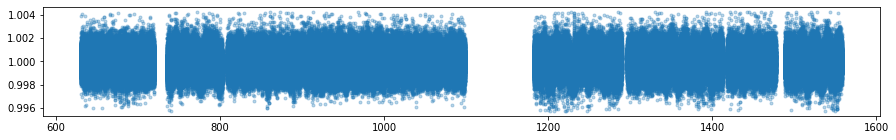

In [588]:
clipped_lc_sc = lc_sc.remove_outliers(sigma=5)

pl.figure(figsize=(15, 2))
pl.plot(clipped_lc_sc.time, clipped_lc_sc.flux, '.',alpha=0.3)
print(np.std(clipped_lc_sc.flux))
print(np.diff(clipped_lc_sc.time)*60*24)

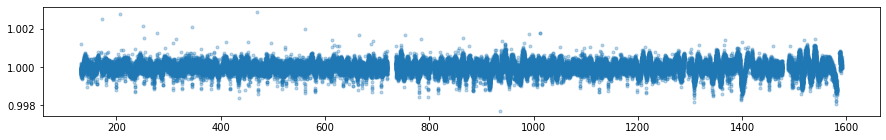

In [6]:
clipped_lc = lc.remove_outliers(sigma=10)

pl.figure(figsize=(15, 2))
pl.plot(clipped_lc.time, clipped_lc.flux, '.', alpha=0.3)

### Compute the power spectrum of the combined Kepler light curve

Text(0.5, 0, 'frequency (1/days)')

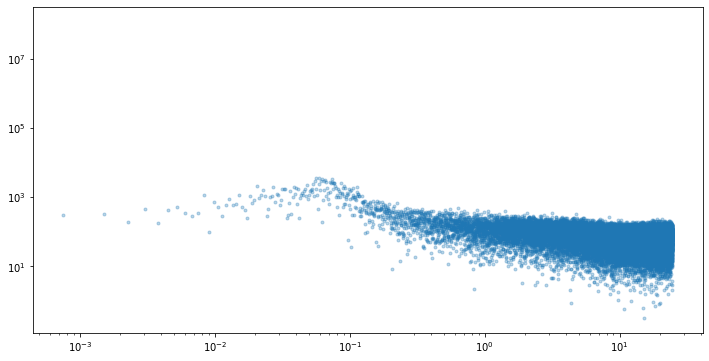

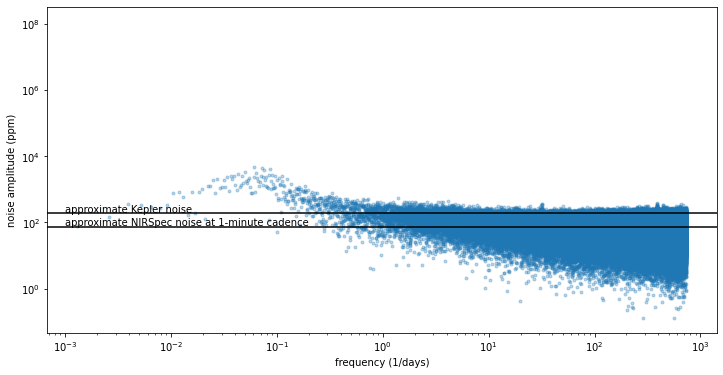

In [666]:
f = np.fft.rfftfreq(len(clipped_lc.flux), clipped_lc.time[1] - clipped_lc.time[0])
fft = np.fft.rfft(clipped_lc.flux)
fft = fft*np.conj(fft)
powerfft = fft.real / len(clipped_lc.time)**2
ampfft = np.sqrt(powerfft * (60 * 60 * 24) / (2*np.pi)) * 1e6

f_sc = np.fft.rfftfreq(len(clipped_lc_sc.flux), clipped_lc_sc.time[1] - clipped_lc_sc.time[0])
fft_sc = np.fft.rfft(clipped_lc_sc.flux)
fft_sc = fft_sc*np.conj(fft_sc)
powerfft_sc = fft_sc.real / len(clipped_lc_sc.time)**2
ampfft_sc = np.sqrt(powerfft_sc * (60 * 60 * 24) / (2*np.pi)) * 1e6

pl.figure(figsize=(12, 6))
pl.loglog(f, ampfft, '.', alpha=0.3)
pl.figure(figsize=(12, 6))
pl.loglog(f_sc, ampfft_sc, '.', alpha=0.3)

pl.axhline(200, color='k')
pl.axhline(72, color='k')
pl.annotate(s='approximate Kepler noise', xy=(1e-3, 200))
pl.annotate(s='approximate NIRSpec noise at 1-minute cadence', xy=(1e-3, 82))

pl.ylabel("noise amplitude (ppm)")
pl.xlabel("frequency (1/days)")

#pl.ylim(1, 1e4)

In [702]:
# approximate white noise of 200 ppm converted to S0 hyperparam
ppm = 200
S0 = (((ppm * 1e-6 ) ** 2) / 50) / 10
print('Maximum S0 value for {0} ppm white noise is {1}'.format(ppm, S0))

Maximum S0 value for 200 ppm white noise is 8e-11


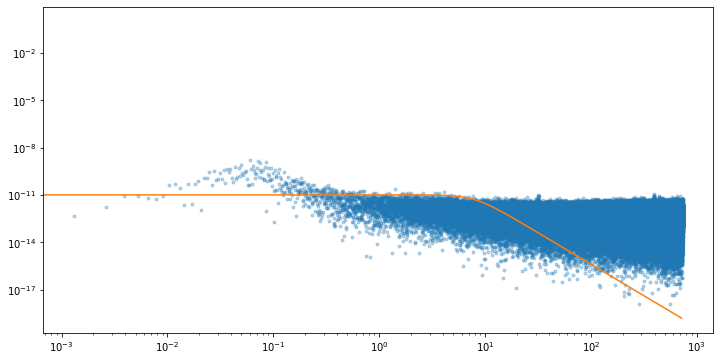

In [700]:
pl.figure(figsize=(12, 6))
pl.loglog(f_sc, powerfft_sc, '.', alpha=0.3)

# just making this up but it looks good 
term = terms.SHOTerm(S0=S0, w0=50, Q=1/np.sqrt(2))

psd = term.get_psd(2*np.pi*f)
psd /= (2*np.pi)

pl.loglog(f, psd)

### Let's say $8\times 10^{-11}$ is an upper limit on $S_0$ then and realize some noise!

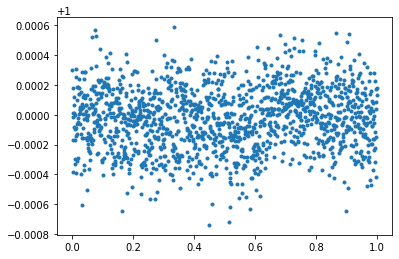

In [694]:
gp = celerite2.GaussianProcess(term, mean=0.0)

# one day
t = np.linspace(0, 1, 1*60*24)
gp.compute(t, yerr = 0)

# A realization of the Kepler granulation component with no white noise 
fk = (gp.dot_tril(np.random.randn(len(t))) + 1)
pl.plot(t, fk + wn(200), '.')

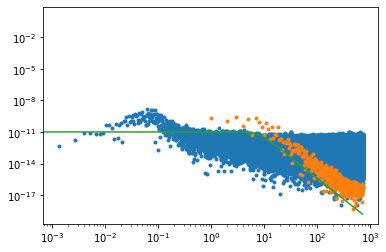

In [695]:
#fk += np.random.randn(len(fk)) * 65 * 1e-6
f = np.fft.rfftfreq(len(fk), t[1]-t[0])
fft = np.fft.rfft(fk)
fft = fft*np.conj(fft)
powerfft = fft.real / len(fk)**2

psd = term.get_psd(2*np.pi*f)
psd /= (2*np.pi)

pl.loglog(f_sc, powerfft_sc, '.')
pl.loglog(f, powerfft, '.')
pl.loglog(f, psd)

In [696]:
import generate_noise
import imp
imp.reload(generate_noise)

factors, data = generate_noise.variability_factors(fk, cold_temp=5700, hot_temp=6200, effective_temp=6000, spec_path='../../JexoSim/archive')

../generate_noise.py:40: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  flux_hot_kep = quad(int_hot_kep, np.min(kep_band[0])/1e3, np.max(kep_band[0])/1e3)
../generate_noise.py:41: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perh

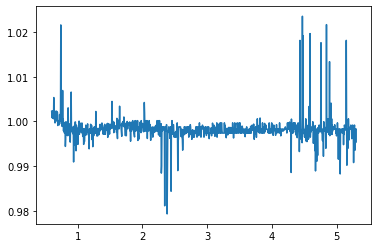

In [697]:
pl.plot(wl, factors[:,0])

(0.9985, 1.0015)

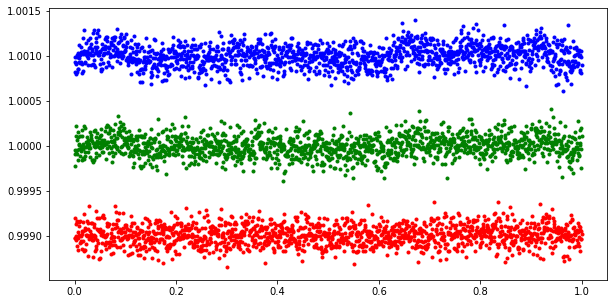

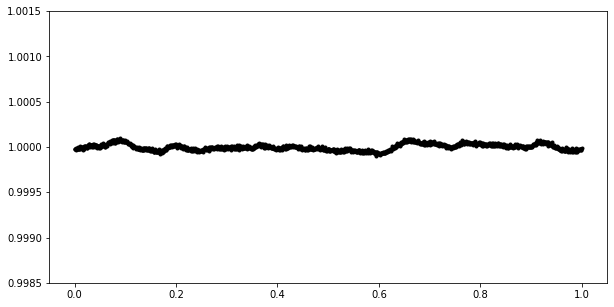

In [698]:
wn = lambda ppm: np.random.randn(len(t)) * ppm * 1e-6

b1 = np.sum(data[:20], axis=0)/np.mean(np.sum(data[:20], axis=0)) + wn(112)
b2 = np.sum(data[20:200], axis=0)/np.mean(np.sum(data[20:200], axis=0)) + wn(112)
b3 = np.sum(data[200:], axis=0)/np.mean(np.sum(data[200:], axis=0)) + wn(112)
ball = np.sum(data, axis=0)/np.mean(np.sum(data, axis=0))

pl.figure(figsize=(10, 5))
pl.plot(t, b1+0.001, 'b.', alpha=1)
pl.plot(t, b2, 'g.', alpha=1)
pl.plot(t, b3-0.001, 'r.', alpha=1)
#pl.plot(t, ball, 'k')
#pl.xlim(0, 1)
pl.figure(figsize=(10, 5))
pl.plot(t, ball + wn(11), 'k.')
pl.ylim(0.9985, 1.0015)

Additional references: 

https://ui.adsabs.harvard.edu/abs/2016MNRAS.457.1089M/abstract
https://ui.adsabs.harvard.edu/abs/2013EPSC....8..960T/abstract
https://ui.adsabs.harvard.edu/abs/2013Sci...340..587B/abstract

In [682]:
K62f['st_teff']

5062.0

In [392]:
5777*1.04

6008.08